In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.core.display import display, HTML
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [2]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'spielberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/'}
        # scorcese

dirs_box_office = {'godard':'https://www.the-numbers.com/person/55430401-Jean-Luc-Godard#tab=technical', \
                   'hitchcock':'https://www.the-numbers.com/person/66230401-Alfred-Hitchcock#tab=technical', \
                   'spielberg': 'https://www.the-numbers.com/person/135430401-Steven-Spielberg#tab=technical',\
                   'allen':'https://www.the-numbers.com/person/4010401-Woody-Allen#tab=technical', \
                   'bergman': 'https://www.the-numbers.com/person/13600401-Ingmar-Bergman#tab=technical',\
                   'herzog':'https://www.the-numbers.com/person/65080401-Werner-Herzog#tab=technical'}

In [3]:
director = 'allen'

In [4]:

dirs_page = dirs[director]
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
#need to distinguish 'filmo-head-director' from 'assistant_director' etc.
head_director_soup = soup.find('div', id='filmo-head-director')
head_director_section_soup= head_director_soup.find_next_sibling('div', class_='filmo-category-section')
films = head_director_section_soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))
#films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [5]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [6]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                return 1
            else:
                return 0
        except:
            return 0
    except:
        return 0

In [7]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        #print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [8]:
def parse_cast_data(the_film_soup):
    try:
        cast_table = the_film_soup.find('table', class_='cast_list').find_all('td', class_='primary_photo')
        cast_list = [(row.find_next_sibling().text.strip(), 1) for row in cast_table ]
        #cast_dict= defaultdict(cast_list)
        #cast_dict.setdefault(1)
        cast_dict = dict(cast_list)
        #print(cast_dict)
        return(cast_dict)
        #return(  the_film_soup.find('table', class_='cast_list').find_all('a', class_='primary_photo').find_next_sibling().text )
        
  #     the_film_soup.find('table', class_='cast_list').find_all('a', class_=re.compile('filmo-row'), id=re.compile("director"))
  #  return the_film_soup.find('table', class_='cast_list').find('a')
    except:
        return dict()

In [9]:
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
#print(the_crew_data)
#print(is_tv_series(test_row))

In [10]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = (film_soup.find(class_ = 'title_wrapper').find('h1').text).strip()
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '').strip(')') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross_imdb']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [11]:
list_of_films = []
dict_of_all_actors = {}

index_ = 0 # temporary for record keeping
for film in films:
    cast_dict = {}
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 0
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 1
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    cast_dict = parse_cast_data(film_soup)
    film_record.update( cast_dict )
    dict_of_all_actors.update( cast_dict )
    #dict_of_all_actors = parse_cast_data(film_soup)
   
    print(index_) # temporary for record keeping
    print(film_record)
    
    list_of_films.append(film_record)
    index_+=1
    
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt8593904/
0
{'title': "Rifkin's Festival", 'year': '2020', 'rating': '6.2', 'rating_count': 717.0, 'duration': 92, 'release_date': ' 2 October 2020 (Spain)    ', 'metacritic_score': '48', 'worldwide_gross_imdb': 441261, 'runtime': 92, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Vittorio Storaro', 'Wallace Shawn': 1, 'Gina Gershon': 1, 'Louis Garrel': 1, 'Elena Anaya': 1, 'Sergi López': 1, 'Richard Kind': 1, 'Nathalie Poza': 1, 'Steve Guttenberg': 1, 'Tammy Blanchard': 1, 'Christoph Waltz': 1, 'Andrea Trepat': 1, 'Carmen Salta': 1, 'Enrique Arce': 1, 'Douglas McGrath': 1, 'Ben Temple': 1}

 https://imdb.com/title/tt7139936/
1
{'title': 'A Rainy Day in New York', 'year': '2019', 'rating': '6.5', 'rating_count': 30069.0, 'duration': 92, 'release_date': ' 10 November 2020 (USA)    ', 'metacritic_score': '38', 'worldwide_gross_imdb': 22002504, 'runtime': 92, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Vittorio Sto

13
{'title': "Cassandra's Dream", 'year': '2007', 'rating': '6.7', 'rating_count': 49973.0, 'duration': 108, 'release_date': ' 18 January 2008 (USA)    ', 'metacritic_score': '49', 'worldwide_gross_imdb': 22687639, 'runtime': 108, 'budget': 13000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Vilmos Zsigmond', 'Ewan McGregor': 1, 'Colin Farrell': 1, 'Peter-Hugo Daly': 1, 'John Benfield': 1, 'Clare Higgins': 1, 'Ashley Madekwe': 1, 'Andrew Howard': 1, 'Hayley Atwell': 1, 'Sally Hawkins': 1, 'Keith Smee': 1, 'Stephen Noonan': 1, 'Dan Carter': 1, 'Richard Lintern': 1, 'Jennifer Higham': 1, 'Lee Whitlock': 1}

 https://imdb.com/title/tt0457513/
14
{'title': 'Scoop', 'year': '2006', 'rating': '6.6', 'rating_count': 80708.0, 'duration': 96, 'release_date': ' 28 July 2006 (USA)    ', 'metacritic_score': '48', 'worldwide_gross_imdb': 39220946, 'runtime': 96, 'budget': 4000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Remi Adefarasin', 'Jim Dunk': 1, 'Robert Bathurst': 1

26
{'title': 'Everyone Says I Love You', 'year': '1996', 'rating': '6.7', 'rating_count': 35316.0, 'duration': 101, 'release_date': ' 17 January 1997 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 9759200, 'runtime': 101, 'budget': 20000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Carlo Di Palma', 'Edward Norton': 1, 'Drew Barrymore': 1, 'Diva Gray': 1, 'Ami Almendral': 1, 'Madeline Balmaceda': 1, 'Vivian Cherry': 1, 'Tommie Baxter': 1, 'Jeff DeRocker': 1, 'Cherylyn Jones': 1, 'Tina Paul': 1, 'Vikki Schnurr': 1, 'Natasha Lyonne': 1, 'Kevin Hagan': 1, 'Alan Alda': 1, 'Gaby Hoffmann': 1}

 https://imdb.com/title/tt0113819/
27
{'title': 'Mighty Aphrodite', 'year': '1995', 'rating': '7.0', 'rating_count': 38006.0, 'duration': 95, 'release_date': ' 10 November 1995 (USA)    ', 'metacritic_score': '59', 'worldwide_gross_imdb': 6468498, 'runtime': 95, 'budget': 15000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Carlo Di Palma', 'Pamela Blair': 1, 'Ren

39
{'title': 'Hannah and Her Sisters', 'year': '1986', 'rating': '7.9', 'rating_count': 67074.0, 'duration': 107, 'release_date': ' 14 March 1986 (USA)    ', 'metacritic_score': '90', 'worldwide_gross_imdb': 40084041, 'runtime': 107, 'budget': 6400000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Carlo Di Palma', 'Barbara Hershey': 1, 'Carrie Fisher': 1, 'Michael Caine': 1, 'Mia Farrow': 1, 'Dianne Wiest': 1, "Maureen O'Sullivan": 1, 'Lloyd Nolan': 1, 'Max von Sydow': 1, 'Woody Allen': 1, 'Lewis Black': 1, 'Julia Louis-Dreyfus': 1, 'Christian Clemenson': 1, 'Julie Kavner': 1, 'J.T. Walsh': 1, 'John Turturro': 1}

 https://imdb.com/title/tt0089853/
40
{'title': 'The Purple Rose of Cairo', 'year': '1985', 'rating': '7.7', 'rating_count': 47032.0, 'duration': 82, 'release_date': ' 19 April 1985 (USA)    ', 'metacritic_score': '75', 'worldwide_gross_imdb': 10631333, 'runtime': 82, 'budget': 15000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Gordon Willis', 'Mia Farrow

52
{'title': 'Bananas', 'year': '1971', 'rating': '7.0', 'rating_count': 33965.0, 'duration': 82, 'release_date': ' 19 July 1971 (Sweden)    ', 'metacritic_score': '67', 'worldwide_gross_imdb': 136200, 'runtime': 82, 'budget': 2000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Andrew M. Costikyan', 'Woody Allen': 1, 'Louise Lasser': 1, 'Carlos Montalbán': 1, 'Nati Abascal': 1, 'Jacobo Morales': 1, 'Miguel Ángel Suárez': 1, 'David Ortiz Angleró': 1, 'René Enríquez': 1, 'Jack Axelrod': 1, 'Howard Cosell': 1, 'Roger Grimsby': 1, 'Don Dunphy': 1, 'Charlotte Rae': 1, 'Stanley Ackerman': 1, 'Dan Frazer': 1}

 https://imdb.com/title/tt0065063/
53
{'title': 'Take the Money and Run', 'year': '1969', 'rating': '7.3', 'rating_count': 28191.0, 'duration': 85, 'release_date': ' 10 July 1970 (Ireland)    ', 'metacritic_score': '67', 'worldwide_gross_imdb': None, 'runtime': 85, 'budget': 1500000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Lester Shorr', 'Woody Allen': 1, 'Janet

In [12]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross_imdb'] = pd.to_numeric(film_catalog['worldwide_gross_imdb'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [13]:
len(film_catalog.columns)

719

In [14]:
len(dict_of_all_actors)

706

In [15]:
len(film_catalog.columns) - len(dict_of_all_actors)

13

In [16]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [17]:
main_column_names = list(film_catalog.columns[:first_cast_column])
main_column_names 

['title',
 'year',
 'rating',
 'rating_count',
 'duration',
 'release_date',
 'metacritic_score',
 'worldwide_gross_imdb',
 'runtime',
 'budget',
 'tv_series',
 'documentary',
 'cinematographer']

In [18]:
film_catalog.iloc[:,first_cast_column:] # temporary, to check work

,Wallace Shawn,Gina Gershon,Louis Garrel,Elena Anaya,Sergi López,Richard Kind,Nathalie Poza,Steve Guttenberg,Tammy Blanchard,Christoph Waltz,...,Ethel Sokolow,The Lovin' Spoonful,Frank Buxton,Julie Bennett,Len Maxwell,Mickey Rose,Bryna Wilson,Tatsuya Mihashi,Mie Hama,Akiko Wakabayashi
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
import copy
df_actors = copy.deepcopy(film_catalog.iloc[:, first_cast_column:])
df_actors

,Wallace Shawn,Gina Gershon,Louis Garrel,Elena Anaya,Sergi López,Richard Kind,Nathalie Poza,Steve Guttenberg,Tammy Blanchard,Christoph Waltz,...,Ethel Sokolow,The Lovin' Spoonful,Frank Buxton,Julie Bennett,Len Maxwell,Mickey Rose,Bryna Wilson,Tatsuya Mihashi,Mie Hama,Akiko Wakabayashi
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_actors.sum().sort_values(ascending = False)

Woody Allen           27.0
Mia Farrow            11.0
Diane Keaton           6.0
Maurice Sonnenberg     5.0
Wallace Shawn          4.0
                      ... 
Arija Bareikis         1.0
Brooke Smith           1.0
Zak Orth               1.0
Will Ferrell           1.0
Akiko Wakabayashi      1.0
Length: 706, dtype: float64

In [21]:
df_actors_reordered = df_actors[df_actors.sum().sort_values(ascending = False).index]
df_actors_reordered

,Woody Allen,Mia Farrow,Diane Keaton,Maurice Sonnenberg,Wallace Shawn,Stephanie Roth Haberle,Dan Frazer,Julie Kavner,John Doumanian,Tony Roberts,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_trunk = copy.deepcopy(film_catalog .iloc[:, :first_cast_column])
df_trunk

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer
0,Rifkin's Festival,2020.0,6.2,717.0,92,2 October 2020 (Spain),48.0,441261.0,92,NaN,0,0,Vittorio Storaro
1,A Rainy Day in New York,2019.0,6.5,30069.0,92,10 November 2020 (USA),38.0,22002504.0,92,NaN,0,0,Vittorio Storaro
2,Wonder Wheel,2017.0,6.2,25189.0,101,15 December 2017 (USA),45.0,15889124.0,101,25000000.0,0,0,Vittorio Storaro
3,Crisis in Six Scenes,NaN,6.6,5376.0,23,30 September 2016 (USA),NaN,NaN,23,NaN,1,0,Eigil Bryld
4,Café Society,2016.0,6.6,71074.0,96,5 August 2016 (USA),64.0,43763247.0,96,30000000.0,0,0,Vittorio Storaro
5,Irrational Man,2015.0,6.6,58674.0,95,7 August 2015 (USA),53.0,27391084.0,95,11000000.0,0,0,Darius Khondji
6,Magic in the Moonlight,2014.0,6.5,64007.0,97,15 August 2014 (USA),54.0,51029361.0,97,16800000.0,0,0,Darius Khondji
7,Blue Jasmine,2013.0,7.3,191724.0,98,23 August 2013 (USA),78.0,99104804.0,98,18000000.0,0,0,Javier Aguirresarobe
8,To Rome With Love,2012.0,6.3,84323.0,112,6 July 2012 (USA),54.0,73244881.0,112,17000000.0,0,0,Darius Khondji
9,Midnight in Paris,2011.0,7.7,387358.0,94,10 June 2011 (USA),81.0,153959590.0,96,17000000.0,0,0,Darius Khondji


In [23]:
film_catalog_cast_columns_reordered = pd.concat( [df_trunk, df_actors_reordered], axis=1)
film_catalog_cast_columns_reordered

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
0,Rifkin's Festival,2020.0,6.2,717.0,92,2 October 2020 (Spain),48.0,441261.0,92,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A Rainy Day in New York,2019.0,6.5,30069.0,92,10 November 2020 (USA),38.0,22002504.0,92,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wonder Wheel,2017.0,6.2,25189.0,101,15 December 2017 (USA),45.0,15889124.0,101,25000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Crisis in Six Scenes,NaN,6.6,5376.0,23,30 September 2016 (USA),NaN,NaN,23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Café Society,2016.0,6.6,71074.0,96,5 August 2016 (USA),64.0,43763247.0,96,30000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Irrational Man,2015.0,6.6,58674.0,95,7 August 2015 (USA),53.0,27391084.0,95,11000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Magic in the Moonlight,2014.0,6.5,64007.0,97,15 August 2014 (USA),54.0,51029361.0,97,16800000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Blue Jasmine,2013.0,7.3,191724.0,98,23 August 2013 (USA),78.0,99104804.0,98,18000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,To Rome With Love,2012.0,6.3,84323.0,112,6 July 2012 (USA),54.0,73244881.0,112,17000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Midnight in Paris,2011.0,7.7,387358.0,94,10 June 2011 (USA),81.0,153959590.0,96,17000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
film_catalog_cast_columns_reordered.iloc[:, :15].head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Woody Allen,Mia Farrow
0,Rifkin's Festival,2020.0,6.2,717.0,92,2 October 2020 (Spain),48.0,441261.0,92,NaN,0,0,Vittorio Storaro,NaN,NaN
1,A Rainy Day in New York,2019.0,6.5,30069.0,92,10 November 2020 (USA),38.0,22002504.0,92,NaN,0,0,Vittorio Storaro,NaN,NaN
2,Wonder Wheel,2017.0,6.2,25189.0,101,15 December 2017 (USA),45.0,15889124.0,101,25000000.0,0,0,Vittorio Storaro,NaN,NaN
3,Crisis in Six Scenes,NaN,6.6,5376.0,23,30 September 2016 (USA),NaN,NaN,23,NaN,1,0,Eigil Bryld,1.0,NaN
4,Café Society,2016.0,6.6,71074.0,96,5 August 2016 (USA),64.0,43763247.0,96,30000000.0,0,0,Vittorio Storaro,NaN,NaN
5,Irrational Man,2015.0,6.6,58674.0,95,7 August 2015 (USA),53.0,27391084.0,95,11000000.0,0,0,Darius Khondji,NaN,NaN
6,Magic in the Moonlight,2014.0,6.5,64007.0,97,15 August 2014 (USA),54.0,51029361.0,97,16800000.0,0,0,Darius Khondji,NaN,NaN
7,Blue Jasmine,2013.0,7.3,191724.0,98,23 August 2013 (USA),78.0,99104804.0,98,18000000.0,0,0,Javier Aguirresarobe,NaN,NaN
8,To Rome With Love,2012.0,6.3,84323.0,112,6 July 2012 (USA),54.0,73244881.0,112,17000000.0,0,0,Darius Khondji,NaN,NaN
9,Midnight in Paris,2011.0,7.7,387358.0,94,10 June 2011 (USA),81.0,153959590.0,96,17000000.0,0,0,Darius Khondji,NaN,NaN


In [25]:
def get_box_office( the_box_office_url):
    response = requests.get(the_box_office_url)
    print( response.status_code )
    box_office_page = response.text
    box_office_soup = BeautifulSoup(box_office_page, "lxml")
    
    box_office_chart = box_office_soup.find('div', id='technical').find('div', id='page_filling_chart')
    box_office_chart_body = box_office_chart.find('table', id='all_technical_credits').find('tbody')
    box_office_chart_body
    box_office_rows = box_office_chart_body.find_all('tr')

    flix_box_office = []
    for row in box_office_rows:
        try:
            title_data = row.find('td').find_next_sibling('td')
            title=(title_data.find('a').text).strip()
        except:
            title=''
        try:
            worldwide_box_office = title_data.find_next_sibling('td').find_next_sibling().find_next_sibling().find_next_sibling().text   
            worldwide_box_office = int( re.sub("[^0-9]", "", worldwide_box_office ))
            flix_box_office.append({'title': title, 'worldwide_gross_bo': float(worldwide_box_office)})
        except:
            flix_box_office.append({'title': title, 'worldwide_gross_bo':''})
    return(pd.DataFrame(flix_box_office))

In [26]:
box_office_df = get_box_office(dirs_box_office[director])

200


In [27]:
film_catalog_cast_columns_reordered.iloc[:, 10:30].head(50)

,tv_series,documentary,cinematographer,Woody Allen,Mia Farrow,Diane Keaton,Maurice Sonnenberg,Wallace Shawn,Stephanie Roth Haberle,Dan Frazer,Julie Kavner,John Doumanian,Tony Roberts,Alan Alda,Paul Herman,Ira Wheeler,Dianne Wiest,Louise Lasser,Douglas McGrath,Scarlett Johansson
0,0,0,Vittorio Storaro,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,0,0,Vittorio Storaro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,Vittorio Storaro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,Eigil Bryld,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,Vittorio Storaro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,0,Darius Khondji,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,0,Darius Khondji,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,0,Javier Aguirresarobe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,Darius Khondji,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,0,Darius Khondji,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [29]:
#director='hitchcock'
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_fc_columns_filename = 'fc_cols_' + director +'.pickle'
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'

In [30]:
#pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
with open(pickled_film_catalog_filename, 'wb') as to_write:
    pickle.dump(film_catalog_cast_columns_reordered, to_write)

In [31]:

with open(pickled_box_office_filename, 'wb') as to_write:
    pickle.dump(box_office_df, to_write)

In [32]:
# film_catalog.columns
with open(pickled_fc_columns_filename, 'wb') as to_write:
    pickle.dump(film_catalog.columns, to_write)

In [33]:
# dict_of_all_actors
with open(pickled_dict_of_actors_filename, 'wb') as to_write:
    pickle.dump(dict_of_all_actors, to_write)

## Retrieve scraped data via pickle

In [182]:
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_misc_vars_filename = 'misc_vars_' + director +'.pickle'

In [183]:
with open(pickled_film_catalog_filename, 'rb') as read_file:
    film_catalog_cast_columns_reordered = pickle.load(read_file)

In [184]:
with open(pickled_box_office_filename, 'rb') as read_file:
    box_office_df = pickle.load(read_file)

In [185]:
with open(pickled_fc_columns_filename, 'rb') as read_file:
    film_catalog_columns = pickle.load(read_file)


In [186]:
with open(pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [187]:
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

### Merging, cleaning, wrangling

In [188]:
films_df = pd.merge(film_catalog_cast_columns_reordered, box_office_df, how='outer', left_on='title', right_on='title')

In [189]:
films_df.head(10)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi,worldwide_gross_bo
0,Rifkin's Festival,2020.0,6.2,717.0,92.0,2 October 2020 (Spain),48.0,441261.0,92.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1301430.0
1,A Rainy Day in New York,2019.0,6.5,30069.0,92.0,10 November 2020 (USA),38.0,22002504.0,92.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18182784.0
2,Wonder Wheel,2017.0,6.2,25189.0,101.0,15 December 2017 (USA),45.0,15889124.0,101.0,25000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13736872.0
3,Crisis in Six Scenes,NaN,6.6,5376.0,23.0,30 September 2016 (USA),NaN,NaN,23.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Café Society,2016.0,6.6,71074.0,96.0,5 August 2016 (USA),64.0,43763247.0,96.0,30000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Irrational Man,2015.0,6.6,58674.0,95.0,7 August 2015 (USA),53.0,27391084.0,95.0,11000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29083597.0
6,Magic in the Moonlight,2014.0,6.5,64007.0,97.0,15 August 2014 (USA),54.0,51029361.0,97.0,16800000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33518508.0
7,Blue Jasmine,2013.0,7.3,191724.0,98.0,23 August 2013 (USA),78.0,99104804.0,98.0,18000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102912961.0
8,To Rome With Love,2012.0,6.3,84323.0,112.0,6 July 2012 (USA),54.0,73244881.0,112.0,17000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Midnight in Paris,2011.0,7.7,387358.0,94.0,10 June 2011 (USA),81.0,153959590.0,96.0,17000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162279328.0


In [190]:
films_df.head()

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi,worldwide_gross_bo
0,Rifkin's Festival,2020.0,6.2,717.0,92.0,2 October 2020 (Spain),48.0,441261.0,92.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1301430.0
1,A Rainy Day in New York,2019.0,6.5,30069.0,92.0,10 November 2020 (USA),38.0,22002504.0,92.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18182784.0
2,Wonder Wheel,2017.0,6.2,25189.0,101.0,15 December 2017 (USA),45.0,15889124.0,101.0,25000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13736872.0
3,Crisis in Six Scenes,NaN,6.6,5376.0,23.0,30 September 2016 (USA),NaN,NaN,23.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Café Society,2016.0,6.6,71074.0,96.0,5 August 2016 (USA),64.0,43763247.0,96.0,30000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
# these renamings are temporary
if('box_office' in films_df.columns):
    films_df.rename(columns={'box_office':'worldwide_gross_bo'}, inplace=True)
    films_df

In [192]:
# these renamings are temporary
if('worldwide_gross' in films_df.columns):
    films_df.rename(columns={'worldwide_gross':'worldwide_gross_imdb'}, inplace=True)

In [193]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [194]:
films_df.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Woody Allen',
       'Mia Farrow'],
      dtype='object')

In [195]:
import copy


films_df_reordered=copy.deepcopy(films_df[[*main_column_names_rearranged, *cast_column_names] ] )                         
                            

In [196]:
films_df_reordered.head(10)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
0,Rifkin's Festival,2020.0,2 October 2020 (Spain),92.0,92.0,NaN,441261.0,1301430.0,6.2,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A Rainy Day in New York,2019.0,10 November 2020 (USA),92.0,92.0,NaN,22002504.0,18182784.0,6.5,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wonder Wheel,2017.0,15 December 2017 (USA),101.0,101.0,25000000.0,15889124.0,13736872.0,6.2,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Crisis in Six Scenes,NaN,30 September 2016 (USA),23.0,23.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Café Society,2016.0,5 August 2016 (USA),96.0,96.0,30000000.0,43763247.0,NaN,6.6,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Irrational Man,2015.0,7 August 2015 (USA),95.0,95.0,11000000.0,27391084.0,29083597.0,6.6,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Magic in the Moonlight,2014.0,15 August 2014 (USA),97.0,97.0,16800000.0,51029361.0,33518508.0,6.5,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Blue Jasmine,2013.0,23 August 2013 (USA),98.0,98.0,18000000.0,99104804.0,102912961.0,7.3,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,To Rome With Love,2012.0,6 July 2012 (USA),112.0,112.0,17000000.0,73244881.0,NaN,6.3,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Midnight in Paris,2011.0,10 June 2011 (USA),94.0,96.0,17000000.0,153959590.0,162279328.0,7.7,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
films_df_reordered.shape

(61, 720)

#### Clean up the `year` column

In [198]:
films_df_reordered['release_date'].fillna('', inplace=True)

In [199]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
0,Rifkin's Festival,2020.0,2 October 2020 (Spain),92.0,92.0,NaN,441261.0,1301430.0,6.2,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A Rainy Day in New York,2019.0,10 November 2020 (USA),92.0,92.0,NaN,22002504.0,18182784.0,6.5,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wonder Wheel,2017.0,15 December 2017 (USA),101.0,101.0,25000000.0,15889124.0,13736872.0,6.2,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Crisis in Six Scenes,NaN,30 September 2016 (USA),23.0,23.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Café Society,2016.0,5 August 2016 (USA),96.0,96.0,30000000.0,43763247.0,NaN,6.6,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,To Rome with Love,NaN,,NaN,NaN,NaN,NaN,74290305.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,You Will Meet a Tall Dark S…,NaN,,NaN,NaN,NaN,NaN,38535748.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,Everything You Always Wante…,NaN,,NaN,NaN,NaN,NaN,18016290.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,Take The Money And Run,NaN,,NaN,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
flix_to_clean_yr = (np.isnan(films_df_reordered['year'])) & (films_df_reordered['release_date']!='') & (films_df_reordered['release_date']!= 'NaN')

In [201]:
#films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years'] = films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years']

In [202]:
# use the release_date column where possible to set missing values in the year column
#films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)

cleaned_yrs = films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)
films_df_reordered.loc[:, 'year'] = cleaned_yrs


In [203]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
11,Whatever Works,2009.0,3 July 2009 (USA),93.0,93.0,15000000.0,36020534.0,35106706.0,7.1,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Vicky Cristina Barcelona,2008.0,15 August 2008 (USA),96.0,96.0,15500000.0,96409300.0,104504817.0,7.1,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Cassandra's Dream,2007.0,18 January 2008 (USA),108.0,108.0,13000000.0,22687639.0,22478138.0,6.7,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Scoop,2006.0,28 July 2006 (USA),96.0,96.0,4000000.0,39220946.0,40103262.0,6.6,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Match Point,2005.0,20 January 2006 (USA),124.0,124.0,15000000.0,85638656.0,87950928.0,7.6,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Melinda and Melinda,2004.0,8 April 2005 (USA),99.0,99.0,NaN,20129327.0,19826280.0,6.4,54.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
17,Anything Else,2003.0,19 September 2003 (USA),108.0,108.0,18000000.0,13585075.0,13203044.0,6.3,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Hollywood Ending,2002.0,3 May 2002 (USA),112.0,112.0,16000000.0,14569744.0,14839383.0,6.6,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Sounds from a Town I Love,2001.0,20 October 2001 (USA),3.0,3.0,NaN,NaN,NaN,6.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,The Concert for New York City,2001.0,20 October 2001 (USA),296.0,296.0,NaN,NaN,NaN,6.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean up the `duration` column

In [204]:
films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)

#### Clean up the `bo_worldwide_gross` column

In [205]:
films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: float(row['worldwide_gross_bo']) if (pd.notna(row['worldwide_gross_bo'])) & (row['worldwide_gross_bo']!='' ) else row['worldwide_gross_imdb'], axis=1)

In [206]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi,worldwide_gross
0,Rifkin's Festival,2020.0,2 October 2020 (Spain),92.0,92.0,NaN,441261.0,1301430.0,6.2,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1301430.0
1,A Rainy Day in New York,2019.0,10 November 2020 (USA),92.0,92.0,NaN,22002504.0,18182784.0,6.5,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18182784.0
2,Wonder Wheel,2017.0,15 December 2017 (USA),101.0,101.0,25000000.0,15889124.0,13736872.0,6.2,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13736872.0
3,Crisis in Six Scenes,2016.0,30 September 2016 (USA),23.0,23.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Café Society,2016.0,5 August 2016 (USA),96.0,96.0,30000000.0,43763247.0,NaN,6.6,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43763247.0
5,Irrational Man,2015.0,7 August 2015 (USA),95.0,95.0,11000000.0,27391084.0,29083597.0,6.6,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29083597.0
6,Magic in the Moonlight,2014.0,15 August 2014 (USA),97.0,97.0,16800000.0,51029361.0,33518508.0,6.5,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33518508.0
7,Blue Jasmine,2013.0,23 August 2013 (USA),98.0,98.0,18000000.0,99104804.0,102912961.0,7.3,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102912961.0
8,To Rome With Love,2012.0,6 July 2012 (USA),112.0,112.0,17000000.0,73244881.0,NaN,6.3,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73244881.0
9,Midnight in Paris,2011.0,10 June 2011 (USA),94.0,96.0,17000000.0,153959590.0,162279328.0,7.7,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162279328.0


#### Remove rows with too many missing values

In [207]:
films_df_reordered.shape

(61, 721)

In [208]:

n=films_df_reordered.iloc[:, :first_cast_column].notna()
n.sum(axis=1).head(50)


0     12
1     12
2     13
3      9
4     12
5     13
6     13
7     13
8     12
9     13
10    12
11    13
12    13
13    13
14    13
15    13
16    12
17    13
18    13
19     9
20     9
21    13
22    13
23    13
24    13
25    13
26    12
27    13
28     9
29    12
30    12
31    12
32    12
33    13
34    13
35    12
36    12
37    12
38    13
39    13
40    13
41    13
42    11
43    12
44    12
45    13
46    13
47    13
48    13
49    13
dtype: int64

In [209]:
first_cast_column

13

In [210]:
thresh=.4
thresh*first_cast_column

5.2

In [211]:
films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi,worldwide_gross
0,Rifkin's Festival,2020.0,2 October 2020 (Spain),92.0,92.0,NaN,441261.0,1301430.0,6.2,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1301430.0
1,A Rainy Day in New York,2019.0,10 November 2020 (USA),92.0,92.0,NaN,22002504.0,18182784.0,6.5,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18182784.0
2,Wonder Wheel,2017.0,15 December 2017 (USA),101.0,101.0,25000000.0,15889124.0,13736872.0,6.2,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13736872.0
3,Crisis in Six Scenes,2016.0,30 September 2016 (USA),23.0,23.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Café Society,2016.0,5 August 2016 (USA),96.0,96.0,30000000.0,43763247.0,NaN,6.6,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43763247.0
5,Irrational Man,2015.0,7 August 2015 (USA),95.0,95.0,11000000.0,27391084.0,29083597.0,6.6,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29083597.0
6,Magic in the Moonlight,2014.0,15 August 2014 (USA),97.0,97.0,16800000.0,51029361.0,33518508.0,6.5,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33518508.0
7,Blue Jasmine,2013.0,23 August 2013 (USA),98.0,98.0,18000000.0,99104804.0,102912961.0,7.3,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102912961.0
8,To Rome With Love,2012.0,6 July 2012 (USA),112.0,112.0,17000000.0,73244881.0,NaN,6.3,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73244881.0
9,Midnight in Paris,2011.0,10 June 2011 (USA),94.0,96.0,17000000.0,153959590.0,162279328.0,7.7,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162279328.0


In [212]:
#films_df_reordered.iloc[70, :].head(30)

In [213]:
films_df_reordered.columns

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating',
       'metacritic_score',
       ...
       'Michael J. Farina', 'Jonny Lee Miller', 'Chloë Sevigny',
       'Matt Servitto', 'Arija Bareikis', 'Brooke Smith', 'Zak Orth',
       'Will Ferrell', 'Akiko Wakabayashi', 'worldwide_gross'],
      dtype='object', length=721)

In [214]:


films_df_reordered = films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column, :] 

In [215]:
films_df_reordered.shape

(55, 721)

#### Clean up outlier rows

In [219]:
films_df_reordered.drop(films_df_reordered[films_df_reordered['title'] == 'The Concert for New York City'].index, inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Cleap up the ordering of columns

In [220]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [221]:
films_df_reordered=films_df_reordered[[*main_column_names_rearranged, *cast_column_names] ] 

In [222]:
films_df_reordered.columns[:20]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross', 'worldwide_gross_imdb', 'worldwide_gross_bo',
       'rating', 'metacritic_score', 'rating_count', 'tv_series',
       'documentary', 'cinematographer', 'Woody Allen', 'Mia Farrow',
       'Diane Keaton', 'Maurice Sonnenberg', 'Wallace Shawn'],
      dtype='object')

In [223]:
films_df_reordered.sort_values(by='title').tail(40)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
3,Crisis in Six Scenes,2016.0,30 September 2016 (USA),23.0,23.0,NaN,NaN,NaN,NaN,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Deconstructing Harry,1997.0,2 January 1998 (USA),96.0,96.0,20000000.0,10686841.0,10686841.0,10686841.0,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Don't Drink the Water,1994.0,18 December 1994 (USA),100.0,100.0,NaN,NaN,NaN,NaN,6.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Everyone Says I Love You,1996.0,17 January 1997 (USA),101.0,101.0,20000000.0,34600000.0,9759200.0,34600000.0,6.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,Everything You Always Wanted to Know About Sex...,1972.0,6 August 1972 (Canada),88.0,88.0,2000000.0,18090065.0,18090065.0,NaN,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Hannah and Her Sisters,1986.0,14 March 1986 (USA),107.0,107.0,6400000.0,40084041.0,40084041.0,40084041.0,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Hollywood Ending,2002.0,3 May 2002 (USA),112.0,112.0,16000000.0,14839383.0,14569744.0,14839383.0,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Husbands and Wives,1992.0,18 September 1992 (USA),108.0,108.0,20000000.0,10555619.0,10555619.0,10555619.0,7.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,Interiors,1978.0,6 October 1978 (Canada),92.0,92.0,10000000.0,10432366.0,10432366.0,10432366.0,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Irrational Man,2015.0,7 August 2015 (USA),95.0,95.0,11000000.0,29083597.0,27391084.0,29083597.0,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In cast columns, replace NaN with zero

In [224]:
#first_cast_column = len(films_df_reordered.columns[15:])

In [225]:
#first_cast_column = len(films_df_reordered.columns) - len(dict_of_all_actors)

In [226]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
0,Rifkin's Festival,2020.0,2 October 2020 (Spain),92.0,92.0,NaN,1301430.0,441261.0,1301430.0,6.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A Rainy Day in New York,2019.0,10 November 2020 (USA),92.0,92.0,NaN,18182784.0,22002504.0,18182784.0,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wonder Wheel,2017.0,15 December 2017 (USA),101.0,101.0,25000000.0,13736872.0,15889124.0,13736872.0,6.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Crisis in Six Scenes,2016.0,30 September 2016 (USA),23.0,23.0,NaN,NaN,NaN,NaN,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Café Society,2016.0,5 August 2016 (USA),96.0,96.0,30000000.0,43763247.0,43763247.0,NaN,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Irrational Man,2015.0,7 August 2015 (USA),95.0,95.0,11000000.0,29083597.0,27391084.0,29083597.0,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Magic in the Moonlight,2014.0,15 August 2014 (USA),97.0,97.0,16800000.0,33518508.0,51029361.0,33518508.0,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Blue Jasmine,2013.0,23 August 2013 (USA),98.0,98.0,18000000.0,102912961.0,99104804.0,102912961.0,7.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,To Rome With Love,2012.0,6 July 2012 (USA),112.0,112.0,17000000.0,73244881.0,73244881.0,NaN,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Midnight in Paris,2011.0,10 June 2011 (USA),94.0,96.0,17000000.0,162279328.0,153959590.0,162279328.0,7.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
films_df_reordered.iloc[:, first_cast_column:]=films_df_reordered.iloc[:, first_cast_column:].replace(np.nan, 0)

In [228]:
films_df_reordered.iloc[:, first_cast_column:].sum()

documentary                                                        0.0
cinematographer      Vittorio StoraroVittorio StoraroVittorio Stora...
Woody Allen                                                       27.0
Mia Farrow                                                        11.0
Diane Keaton                                                       6.0
                                           ...                        
Arija Bareikis                                                     1.0
Brooke Smith                                                       1.0
Zak Orth                                                           1.0
Will Ferrell                                                       1.0
Akiko Wakabayashi                                                  1.0
Length: 708, dtype: object

In [229]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
4,Café Society,2016.0,5 August 2016 (USA),96.0,96.0,30000000.0,43763247.0,43763247.0,NaN,6.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Irrational Man,2015.0,7 August 2015 (USA),95.0,95.0,11000000.0,29083597.0,27391084.0,29083597.0,6.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Magic in the Moonlight,2014.0,15 August 2014 (USA),97.0,97.0,16800000.0,33518508.0,51029361.0,33518508.0,6.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Blue Jasmine,2013.0,23 August 2013 (USA),98.0,98.0,18000000.0,102912961.0,99104804.0,102912961.0,7.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,To Rome With Love,2012.0,6 July 2012 (USA),112.0,112.0,17000000.0,73244881.0,73244881.0,NaN,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Midnight in Paris,2011.0,10 June 2011 (USA),94.0,96.0,17000000.0,162279328.0,153959590.0,162279328.0,7.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,You Will Meet a Tall Dark Stranger,2010.0,22 October 2010 (USA),98.0,98.0,22000000.0,36015260.0,36015260.0,NaN,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,Whatever Works,2009.0,3 July 2009 (USA),93.0,93.0,15000000.0,35106706.0,36020534.0,35106706.0,7.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,Vicky Cristina Barcelona,2008.0,15 August 2008 (USA),96.0,96.0,15500000.0,104504817.0,96409300.0,104504817.0,7.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,Cassandra's Dream,2007.0,18 January 2008 (USA),108.0,108.0,13000000.0,22478138.0,22687639.0,22478138.0,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
films_df_reordered.dtypes[:15]

title                    object
year                    float64
release_date             object
duration                float64
runtime                 float64
budget                  float64
worldwide_gross         float64
worldwide_gross_imdb    float64
worldwide_gross_bo       object
rating                  float64
metacritic_score        float64
rating_count            float64
tv_series               float64
documentary             float64
cinematographer          object
dtype: object

In [231]:
films_df_reordered.iloc[:, :first_cast_column].head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series
0,Rifkin's Festival,2020.0,2 October 2020 (Spain),92.0,92.0,NaN,1301430.0,441261.0,1301430.0,6.2,48.0,717.0,0.0
1,A Rainy Day in New York,2019.0,10 November 2020 (USA),92.0,92.0,NaN,18182784.0,22002504.0,18182784.0,6.5,38.0,30069.0,0.0
2,Wonder Wheel,2017.0,15 December 2017 (USA),101.0,101.0,25000000.0,13736872.0,15889124.0,13736872.0,6.2,45.0,25189.0,0.0
3,Crisis in Six Scenes,2016.0,30 September 2016 (USA),23.0,23.0,NaN,NaN,NaN,NaN,6.6,NaN,5376.0,1.0
4,Café Society,2016.0,5 August 2016 (USA),96.0,96.0,30000000.0,43763247.0,43763247.0,NaN,6.6,64.0,71074.0,0.0
5,Irrational Man,2015.0,7 August 2015 (USA),95.0,95.0,11000000.0,29083597.0,27391084.0,29083597.0,6.6,53.0,58674.0,0.0
6,Magic in the Moonlight,2014.0,15 August 2014 (USA),97.0,97.0,16800000.0,33518508.0,51029361.0,33518508.0,6.5,54.0,64007.0,0.0
7,Blue Jasmine,2013.0,23 August 2013 (USA),98.0,98.0,18000000.0,102912961.0,99104804.0,102912961.0,7.3,78.0,191724.0,0.0
8,To Rome With Love,2012.0,6 July 2012 (USA),112.0,112.0,17000000.0,73244881.0,73244881.0,NaN,6.3,54.0,84323.0,0.0
9,Midnight in Paris,2011.0,10 June 2011 (USA),94.0,96.0,17000000.0,162279328.0,153959590.0,162279328.0,7.7,81.0,387358.0,0.0


In [232]:
films_df_reordered["worldwide_gross"] = pd.to_numeric(films_df_reordered["worldwide_gross"])

In [233]:
films_df_reordered.iloc[:,:first_cast_column].corr()

,year,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series
year,1.000000,0.167806,0.169725,0.656383,0.395998,0.415571,-0.347458,-0.545325,0.212355,0.018110
duration,0.167806,1.000000,0.999917,0.338268,0.217617,0.216857,0.125619,-0.278075,0.223173,-0.732139
runtime,0.169725,0.999917,1.000000,0.340133,0.235487,0.234353,0.128019,-0.271835,0.231362,-0.732444
budget,0.656383,0.338268,0.340133,1.000000,0.099396,0.093695,-0.283062,-0.334254,-0.015236,NaN
worldwide_gross,0.395998,0.217617,0.235487,0.099396,1.000000,0.984294,0.205326,0.290685,0.903307,NaN
worldwide_gross_imdb,0.415571,0.216857,0.234353,0.093695,0.984294,1.000000,0.197435,0.277168,0.897558,NaN
rating,-0.347458,0.125619,0.128019,-0.283062,0.205326,0.197435,1.000000,0.822540,0.439364,-0.303845
metacritic_score,-0.545325,-0.278075,-0.271835,-0.334254,0.290685,0.277168,0.822540,1.000000,0.427300,NaN
rating_count,0.212355,0.223173,0.231362,-0.015236,0.903307,0.897558,0.439364,0.427300,1.000000,-0.211528
tv_series,0.018110,-0.732139,-0.732444,NaN,NaN,NaN,-0.303845,NaN,-0.211528,1.000000


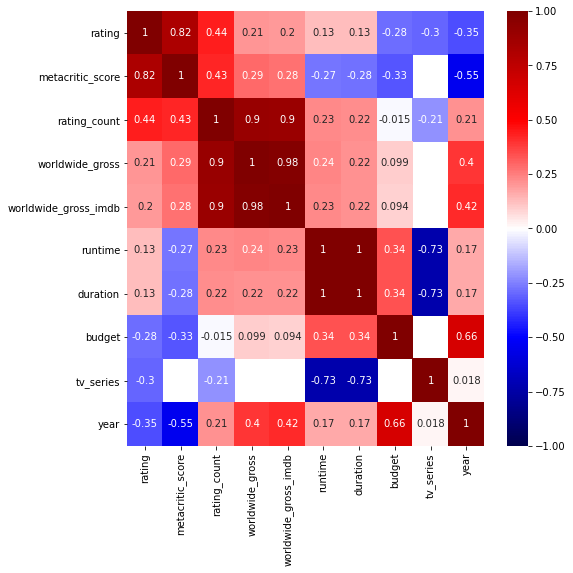

In [234]:
ix = films_df_reordered.iloc[:,:first_cast_column].corr().sort_values('rating', ascending=False).index
films_df_reordered_sorted = films_df_reordered.loc[:, ix]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(films_df_reordered_sorted.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);

In [235]:
#sns.heatmap(films_df_reordered.iloc[:,:first_cast_column].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

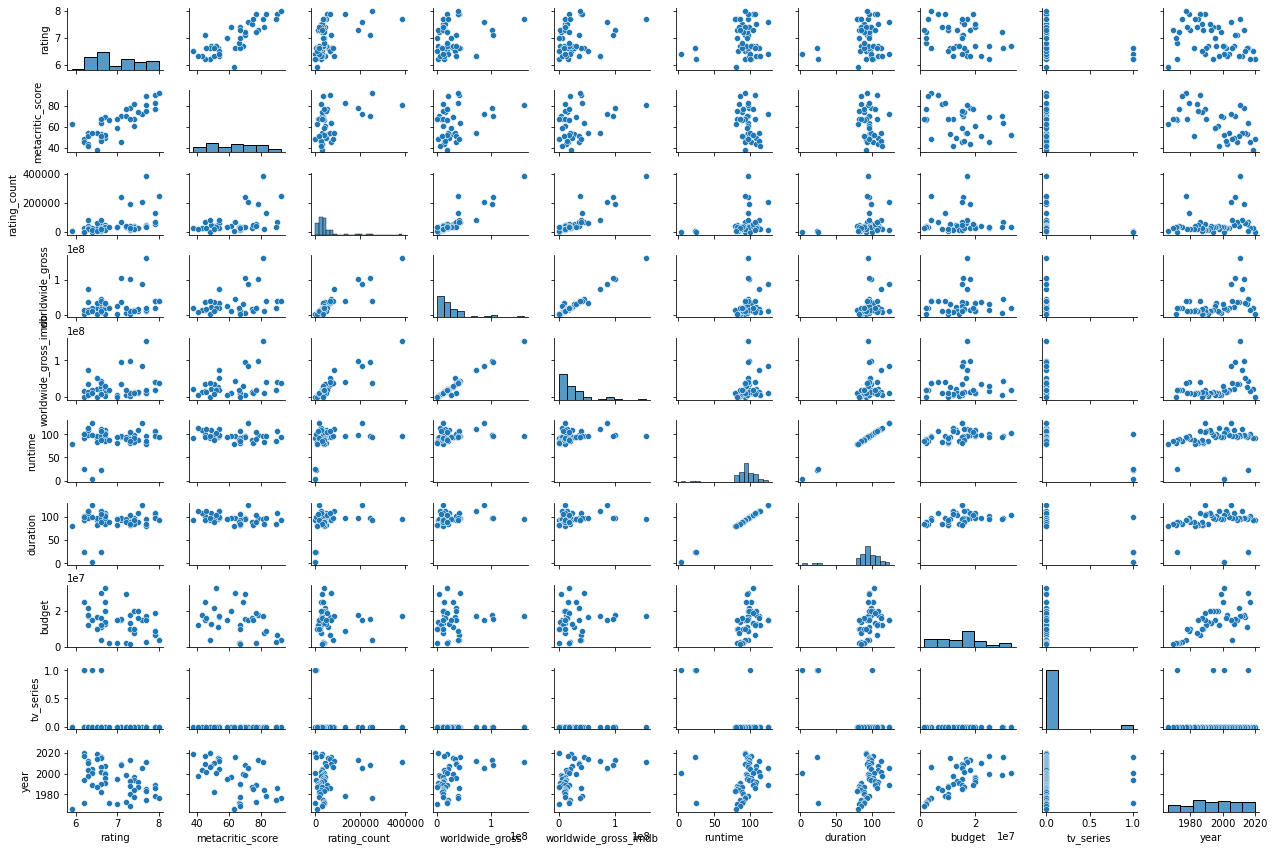

In [236]:
sns.pairplot(films_df_reordered_sorted.iloc[:,:first_cast_column], height=1.2, aspect=1.5);

#### Determine which columns have enough non-null values so they could be used

In [237]:
films_df_reordered['worldwide_gross'].value_counts(dropna=False)

NaN            6
10631333.0     1
4196621.0      1
35106706.0     1
2735731.0      1
18182784.0     1
11798616.0     1
104504817.0    1
18254702.0     1
102912961.0    1
18496522.0     1
486434.0       1
11330911.0     1
1301430.0      1
136200.0       1
40053595.0     1
1562749.0      1
6200000.0      1
87950928.0     1
19826280.0     1
18344729.0     1
7331647.0      1
10763469.0     1
22478138.0     1
13383747.0     1
162279328.0    1
36015260.0     1
10600497.0     1
10686841.0     1
38251425.0     1
10555619.0     1
20123742.0     1
73244881.0     1
14792779.0     1
10432366.0     1
29083597.0     1
43763247.0     1
9077269.0      1
40084041.0     1
26000000.0     1
18090065.0     1
13203044.0     1
34600000.0     1
40103262.0     1
29934477.0     1
13736872.0     1
10389003.0     1
33518508.0     1
14839383.0     1
Name: worldwide_gross, dtype: int64

In [238]:
films_to_analyze=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
films_to_analyze.iloc[:,5:15].head(10)


,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
0,NaN,1301430.0,441261.0,1301430.0,6.2,48.0,717.0,0.0,0.0,Vittorio Storaro
1,NaN,18182784.0,22002504.0,18182784.0,6.5,38.0,30069.0,0.0,0.0,Vittorio Storaro
2,25000000.0,13736872.0,15889124.0,13736872.0,6.2,45.0,25189.0,0.0,0.0,Vittorio Storaro
4,30000000.0,43763247.0,43763247.0,NaN,6.6,64.0,71074.0,0.0,0.0,Vittorio Storaro
5,11000000.0,29083597.0,27391084.0,29083597.0,6.6,53.0,58674.0,0.0,0.0,Darius Khondji
6,16800000.0,33518508.0,51029361.0,33518508.0,6.5,54.0,64007.0,0.0,0.0,Darius Khondji
7,18000000.0,102912961.0,99104804.0,102912961.0,7.3,78.0,191724.0,0.0,0.0,Javier Aguirresarobe
8,17000000.0,73244881.0,73244881.0,NaN,6.3,54.0,84323.0,0.0,0.0,Darius Khondji
9,17000000.0,162279328.0,153959590.0,162279328.0,7.7,81.0,387358.0,0.0,0.0,Darius Khondji
10,22000000.0,36015260.0,36015260.0,NaN,6.3,51.0,43795.0,0.0,0.0,Vilmos Zsigmond


In [239]:
first_actor_column = (len(films_to_analyze.columns) - len(dict_of_all_actors))
first_actor_column

15

In [240]:
actor_columns = films_to_analyze.iloc[:, first_actor_column:].columns
actor_columns

Index(['Woody Allen', 'Mia Farrow', 'Diane Keaton', 'Maurice Sonnenberg',
       'Wallace Shawn', 'Stephanie Roth Haberle', 'Dan Frazer', 'Julie Kavner',
       'John Doumanian', 'Tony Roberts',
       ...
       'Radha Mitchell', 'Michael J. Farina', 'Jonny Lee Miller',
       'Chloë Sevigny', 'Matt Servitto', 'Arija Bareikis', 'Brooke Smith',
       'Zak Orth', 'Will Ferrell', 'Akiko Wakabayashi'],
      dtype='object', length=706)

In [241]:
films_to_analyze[actor_columns].sum()

Woody Allen           25.0
Mia Farrow            11.0
Diane Keaton           6.0
Maurice Sonnenberg     5.0
Wallace Shawn          4.0
                      ... 
Arija Bareikis         1.0
Brooke Smith           1.0
Zak Orth               1.0
Will Ferrell           1.0
Akiko Wakabayashi      1.0
Length: 706, dtype: float64

In [242]:
actors_num_of_appearances = films_to_analyze[actor_columns].sum()
actors_num_of_appearances

Woody Allen           25.0
Mia Farrow            11.0
Diane Keaton           6.0
Maurice Sonnenberg     5.0
Wallace Shawn          4.0
                      ... 
Arija Bareikis         1.0
Brooke Smith           1.0
Zak Orth               1.0
Will Ferrell           1.0
Akiko Wakabayashi      1.0
Length: 706, dtype: float64

In [243]:
appearances_threshold = 3
prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Woody Allen            True
Mia Farrow             True
Diane Keaton           True
Maurice Sonnenberg     True
Wallace Shawn          True
                      ...  
Arija Bareikis        False
Brooke Smith          False
Zak Orth              False
Will Ferrell          False
Akiko Wakabayashi     False
Length: 706, dtype: bool

In [244]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 

Index(['Woody Allen', 'Mia Farrow', 'Diane Keaton', 'Maurice Sonnenberg',
       'Wallace Shawn', 'Stephanie Roth Haberle', 'Dan Frazer', 'Julie Kavner',
       'John Doumanian', 'Tony Roberts', 'Alan Alda', 'Paul Herman',
       'Ira Wheeler', 'Dianne Wiest', 'Louise Lasser', 'Douglas McGrath',
       'Scarlett Johansson', 'Sam Waterston'],
      dtype='object')

#### These next few cells are legacy  -----------------------------------------

#### End of legacy code  -----------------------------------------

In [245]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [246]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Woody Allen',
 'Mia Farrow',
 'Diane Keaton',
 'Maurice Sonnenberg',
 'Wallace Shawn',
 'Stephanie Roth Haberle',
 'Dan Frazer',
 'Julie Kavner',
 'John Doumanian',
 'Tony Roberts',
 'Alan Alda',
 'Paul Herman',
 'Ira Wheeler',
 'Dianne Wiest',
 'Louise Lasser',
 'Douglas McGrath',
 'Scarlett Johansson',
 'Sam Waterston']

## Dataset partitioned for analysis

In [247]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [248]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

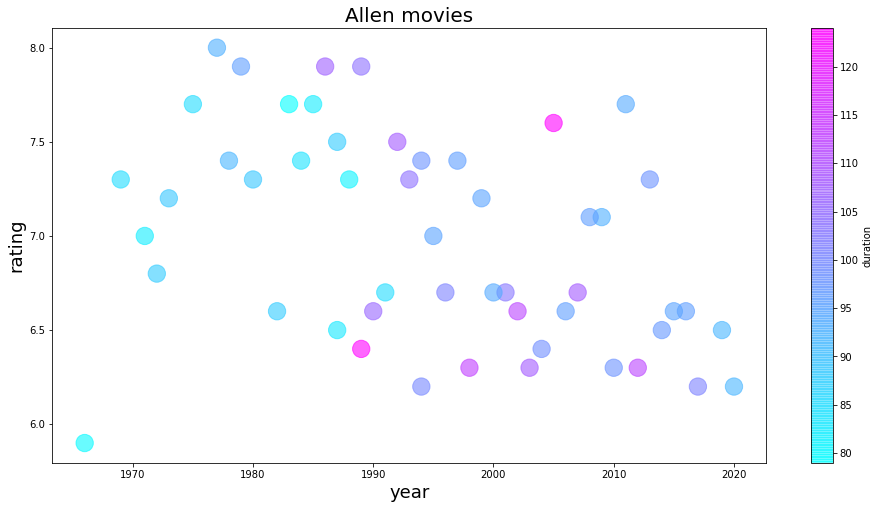

In [249]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'duration'
cm=films_and_features_to_analyze_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

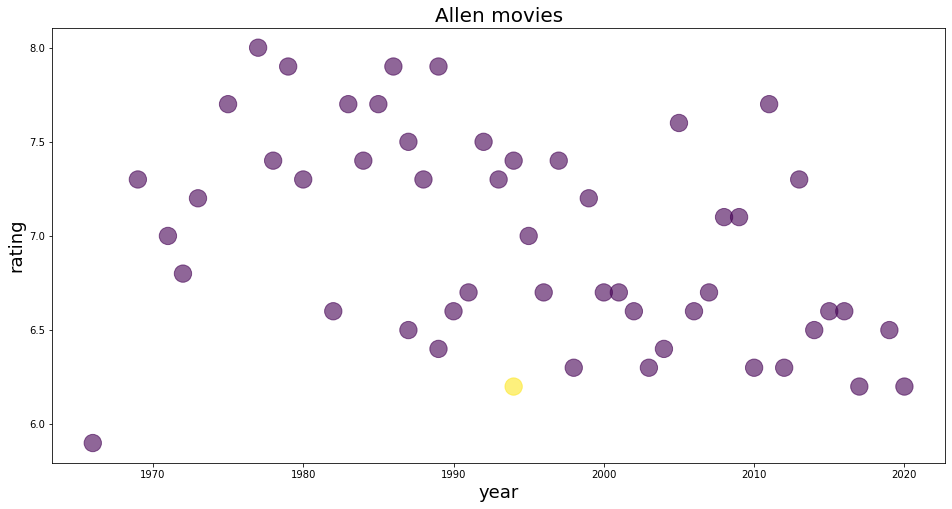

In [250]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [251]:
x_label = 'year'
y_label = 'duration'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

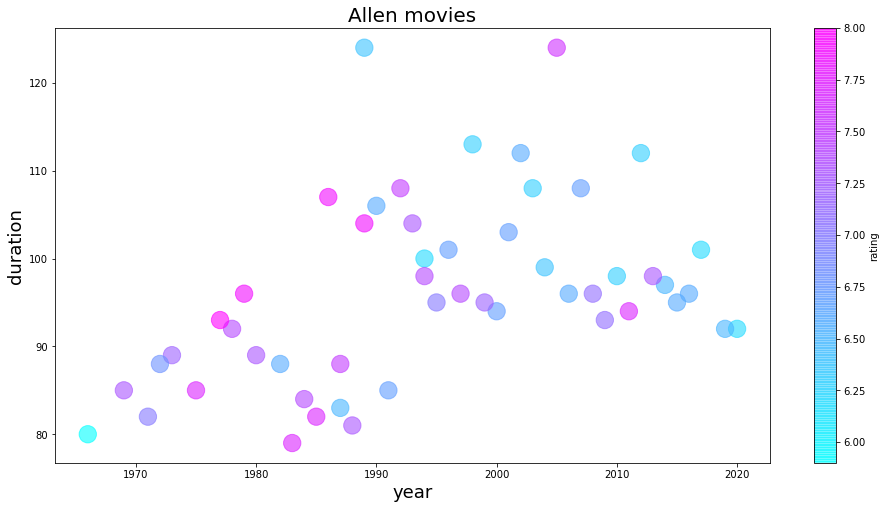

In [252]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating'
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

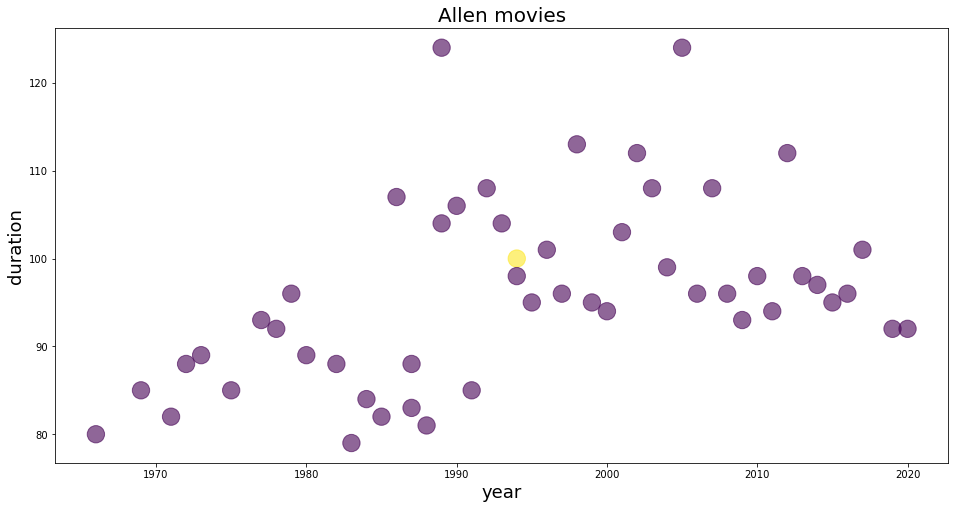

In [253]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


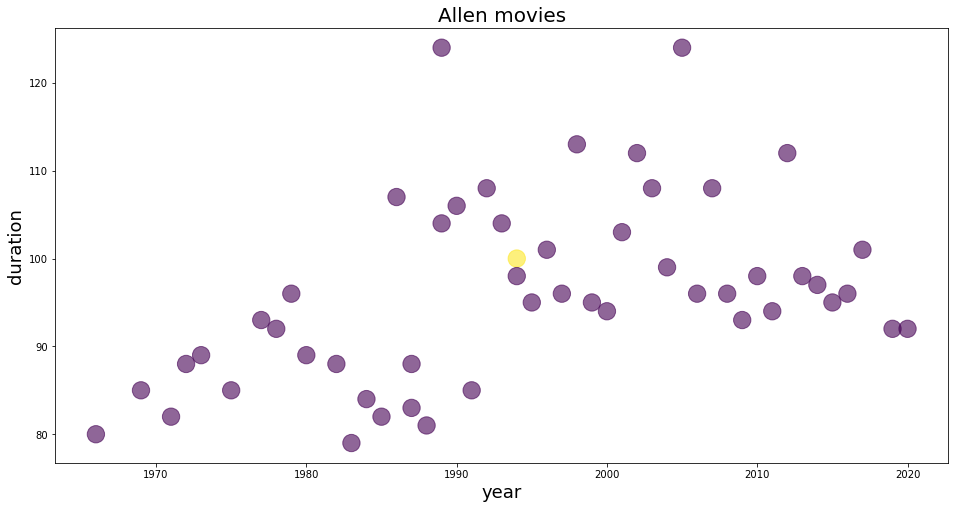

In [254]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


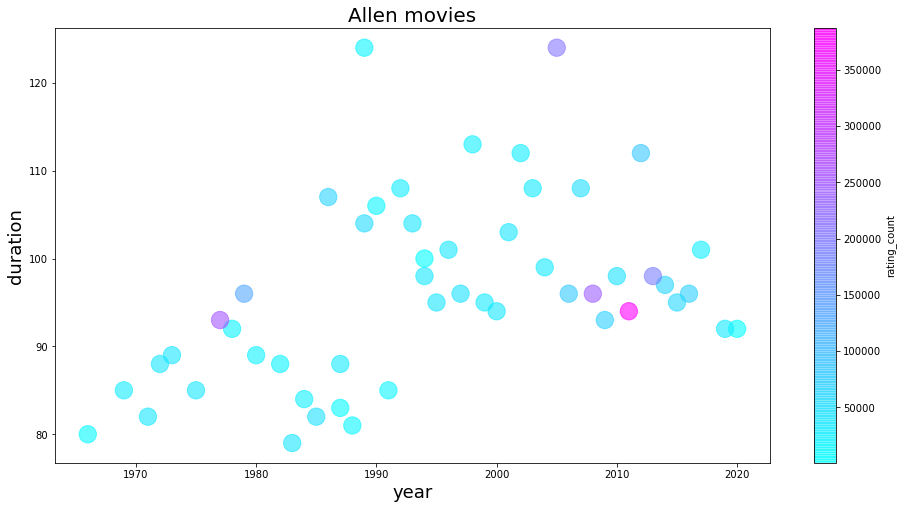

In [255]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating_count'
cmap=plt.get_cmap("cool")
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )
#plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [256]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

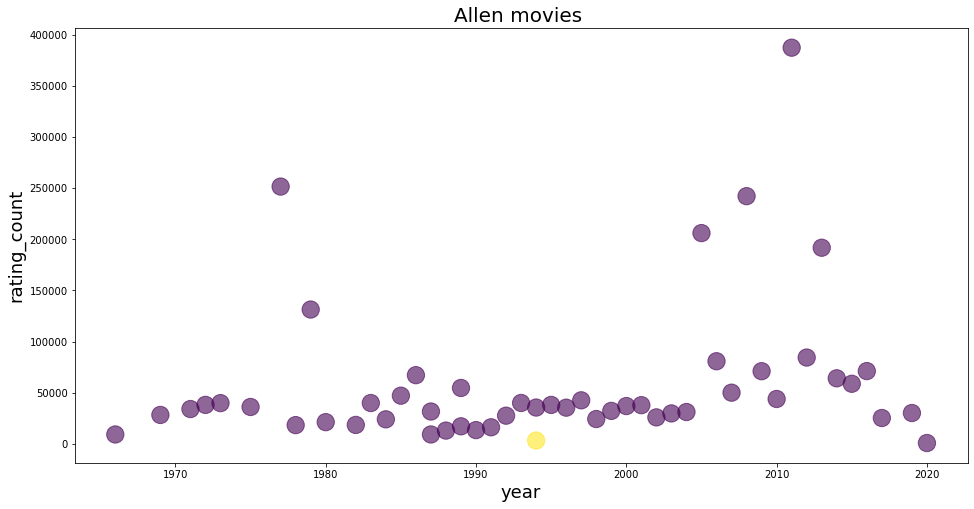

In [257]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


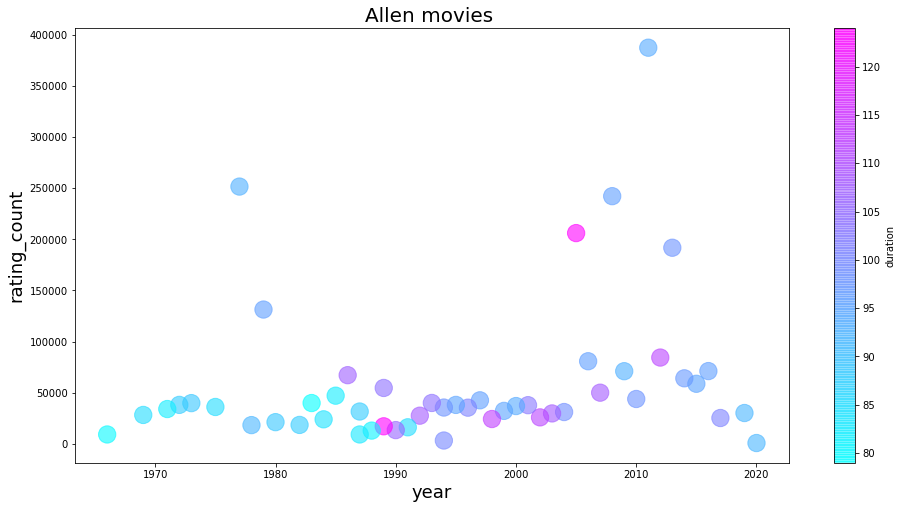

In [258]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[color_dimension ].tolist()
cmap=plt.get_cmap("cool")
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [259]:
#films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1]

In [260]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][x_label]
y_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][y_label]

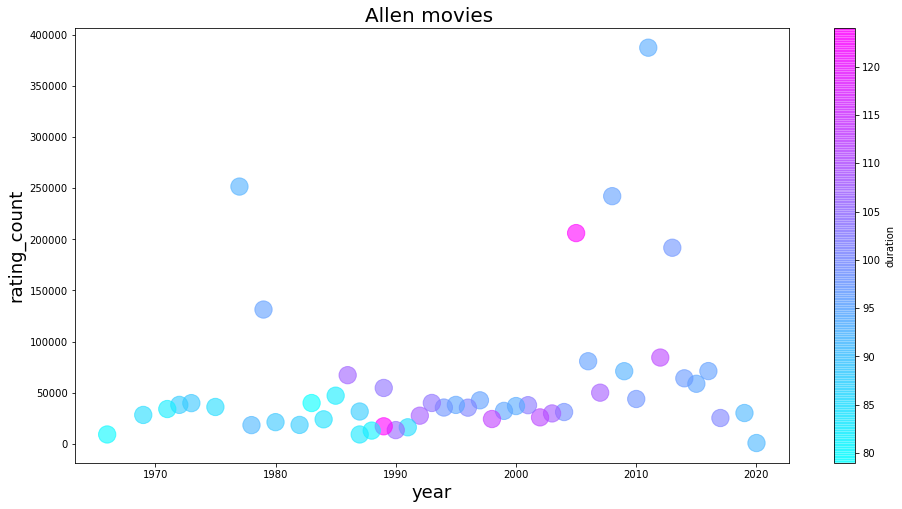

In [261]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][color_dimension ].tolist()
cmap=plt.get_cmap("cool")
#category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [262]:
print( min(x_), max(x_))

1966.0 2020.0


In [263]:
from scipy import signal
signal.unit_impulse(1960) # come back to this to attempt to model "dirac impulse response" 
# for rating count based on year

array([1., 0., 0., ..., 0., 0., 0.])

In [264]:
films_and_features_to_analyze_df[films_and_features_to_analyze_df['duration'] <65]

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Woody Allen,Mia Farrow,...,John Doumanian,Tony Roberts,Alan Alda,Paul Herman,Ira Wheeler,Dianne Wiest,Louise Lasser,Douglas McGrath,Scarlett Johansson,Sam Waterston


#### Breakdown by **cinematographers** Jack E. Cox, Robert Burks, and Bernard Knowles 

In [265]:
cinematographer = 'Jack E. Cox'

In [266]:
ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


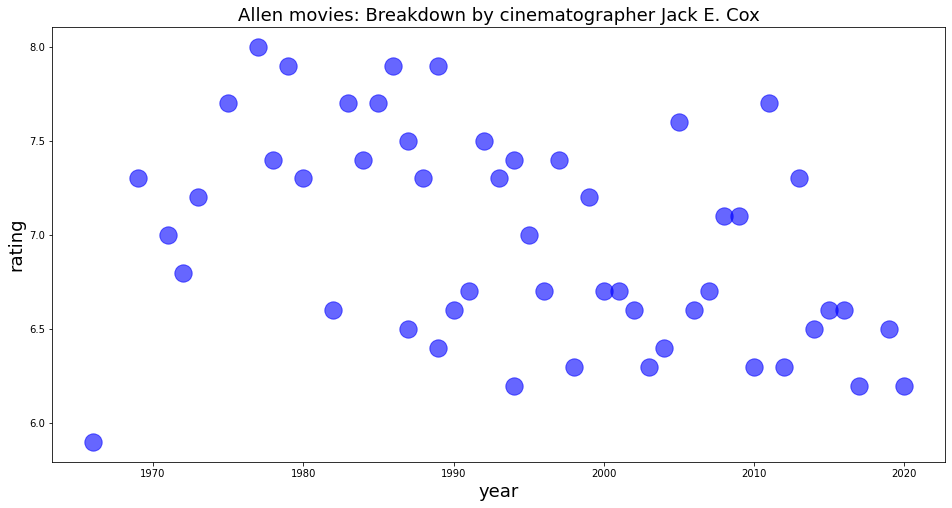

In [267]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [ ]:
cinematographer = 'Robert Burks'

In [ ]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


In [ ]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [ ]:
cinematographer = 'Bernard Knowles'

In [ ]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


In [ ]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: ' + 'Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

#### Recode misc. cinematographers to `OTHER` to ameliorate issue of not dropping a column and also to increase the chance it will occur in the test set as well

In [268]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [269]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Train Test Split

In [270]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Woody Allen', 'Mia Farrow',
       'Diane Keaton', 'Maurice Sonnenberg', 'Wallace Shawn',
       'Stephanie Roth Haberle', 'Dan Frazer', 'Julie Kavner',
       'John Doumanian', 'Tony Roberts', 'Alan Alda', 'Paul Herman',
       'Ira Wheeler', 'Dianne Wiest', 'Louise Lasser', 'Douglas McGrath',
       'Scarlett Johansson', 'Sam Waterston'],
      dtype='object')

In [271]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [272]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

#### Categorical Variable Preprocessing

In [274]:
cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [275]:
#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


In [276]:
columns=ohe.get_feature_names(cat_ohe_vars)

columns

array(['cinematographer_Carlo Di Palma', 'cinematographer_Darius Khondji',
       'cinematographer_David M. Walsh', 'cinematographer_Fei Zhao',
       'cinematographer_Gordon Willis',
       'cinematographer_Javier Aguirresarobe', 'cinematographer_OTHER',
       'cinematographer_Remi Adefarasin', 'cinematographer_Sven Nykvist',
       'cinematographer_Vilmos Zsigmond',
       'cinematographer_Vittorio Storaro'], dtype=object)

In [277]:
X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

,cinematographer_Carlo Di Palma,cinematographer_Darius Khondji,cinematographer_David M. Walsh,cinematographer_Fei Zhao,cinematographer_Gordon Willis,cinematographer_Javier Aguirresarobe,cinematographer_OTHER,cinematographer_Remi Adefarasin,cinematographer_Sven Nykvist,cinematographer_Vilmos Zsigmond,cinematographer_Vittorio Storaro
54,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
45,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Repeating transformations on testing set

In [278]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [279]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head(70)



,year,duration,rating_count
54,1966.0,80.0,9091.0
27,1995.0,95.0,38006.0
15,2005.0,124.0,206030.0
45,1979.0,96.0,131272.0
2,2017.0,101.0,25189.0
44,1980.0,89.0,21138.0
25,1997.0,96.0,42494.0
23,1999.0,95.0,32161.0
22,2000.0,94.0,36880.0
17,2003.0,108.0,29669.0


####  scale the continuous variables in the train set

In [280]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
54,-2.023148,-1.623026,-0.658478
27,0.050814,-0.133292,-0.259140
15,0.765973,2.746861,2.061394
45,-1.093441,-0.033976,1.028932
2,1.624164,0.462602,-0.436152


#### select and scale the continuous variables in the test set

In [281]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
7,2013.0,98.0,191724.0
29,1994.0,98.0,35436.0
14,2006.0,96.0,80708.0
47,1977.0,93.0,251536.0
0,2020.0,92.0,717.0


In [282]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
7,1.338101,0.164655,1.863818
29,-0.020702,0.164655,-0.294634
14,0.837489,-0.033976,0.330606
47,-1.236473,-0.331923,2.689866
0,1.838712,-0.431239,-0.774129


### Combine the continuous, categorical, and ohe cat features for our testing set


In [283]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


In [284]:
X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

,year,duration,rating_count,cinematographer_Carlo Di Palma,cinematographer_Darius Khondji,cinematographer_David M. Walsh,cinematographer_Fei Zhao,cinematographer_Gordon Willis,cinematographer_Javier Aguirresarobe,cinematographer_OTHER,...,John Doumanian,Tony Roberts,Alan Alda,Paul Herman,Ira Wheeler,Dianne Wiest,Louise Lasser,Douglas McGrath,Scarlett Johansson,Sam Waterston
54,-2.023148,-1.623026,-0.658478,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27,0.050814,-0.133292,-0.259140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.765973,2.746861,2.061394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45,-1.093441,-0.033976,1.028932,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.624164,0.462602,-0.436152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,-1.021925,-0.729186,-0.492100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.193846,-0.033976,-0.197158,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.336878,-0.133292,-0.339864,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.408394,-0.232608,-0.274691,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.622941,1.157811,-0.374280,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
X_train.shape

(38, 24)

### Combine the continuous and categorical features for our testing set


In [286]:
X_test_cat_df = X_test[cat_columns]

In [287]:
X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


True

In [288]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

,year,duration,rating_count,cinematographer_Carlo Di Palma,cinematographer_Darius Khondji,cinematographer_David M. Walsh,cinematographer_Fei Zhao,cinematographer_Gordon Willis,cinematographer_Javier Aguirresarobe,cinematographer_OTHER,...,John Doumanian,Tony Roberts,Alan Alda,Paul Herman,Ira Wheeler,Dianne Wiest,Louise Lasser,Douglas McGrath,Scarlett Johansson,Sam Waterston
0,1.338101,0.164655,1.863818,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.020702,0.164655,-0.294634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.837489,-0.033976,0.330606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.236473,-0.331923,2.689866,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.838712,-0.431239,-0.774129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,-1.808600,-1.126448,-0.394693,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.521313,-0.828501,-0.348316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.123553,0.164655,-0.179190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.378282,2.746861,-0.548296,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.265362,1.654389,-0.449894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Now make predictions by instantiating the Linear Regression Model 

In [289]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

LinearRegression()

In [290]:
lr.coef_

array([ 1.19871727e-01, -1.36129682e-01,  3.69917709e-01,  9.95265057e-02,
       -5.23933790e-01,  2.46667855e-01, -6.17254899e-01,  4.89637970e-01,
       -2.65396162e-01,  6.14828942e-02,  2.59121247e-01,  9.86434046e-01,
        2.83803145e-02, -7.64665982e-01, -5.55111512e-16, -1.74719448e+00,
        6.88767436e-01, -5.31664462e-01, -1.51345135e-01, -5.64255732e-01,
        1.76111313e-01, -6.98794308e-01,  5.51412554e-01,  6.17914233e-01,
        3.91386860e-01, -6.32439148e-01, -9.41221003e-02,  2.22044605e-16,
       -3.63586847e-01,  2.57875185e-01, -1.10868346e+00, -1.44097574e-02,
       -6.27491515e-03,  3.60193164e-01])

In [291]:
y_pred = lr.predict(X_test_combined)

y_pred

array([7.42876727, 7.09023351, 7.34687778, 8.15333465, 6.25650374,
       7.95892018, 7.68171469, 6.94108069, 6.09961832, 6.91466077,
       6.36587433, 6.88920957, 7.4241871 ])

In [292]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.46
r2: 0.39


In [293]:
print(r2)

0.3929371463697562


In [294]:
score = lr.score(X_test_combined, y_test) 
score

0.3929371463697562

# Focus on building up from fewer features

### Train Test Split

In [295]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Woody Allen', 'Mia Farrow',
       'Diane Keaton', 'Maurice Sonnenberg', 'Wallace Shawn',
       'Stephanie Roth Haberle', 'Dan Frazer', 'Julie Kavner',
       'John Doumanian', 'Tony Roberts', 'Alan Alda', 'Paul Herman',
       'Ira Wheeler', 'Dianne Wiest', 'Louise Lasser', 'Douglas McGrath',
       'Scarlett Johansson', 'Sam Waterston'],
      dtype='object')

In [296]:
selected_cols = ['year', 'duration', 'rating_count']

In [297]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

## For now, ignore these categorical variables

#### Categorical Variable Preprocessing

#### OneHotEncoding

#### Repeating transformations on testing set

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [299]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head()



,year,duration,rating_count
15,2005.0,124.0,206030.0
4,2016.0,96.0,71074.0
8,2012.0,112.0,84323.0
26,1996.0,101.0,35316.0
39,1986.0,107.0,67074.0


####  scale the continuous variables in the train set

In [300]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
15,0.794458,2.487644,2.594313
4,1.594659,-0.028376,0.289731
8,1.303677,1.409350,0.515978
26,0.139748,0.420913,-0.320893
39,-0.587708,0.960060,0.221424


#### select and scale the continuous variables in the test set

In [301]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
21,2001.0,103.0,37732.0
9,2011.0,94.0,387358.0
10,2010.0,98.0,43795.0
2,2017.0,101.0,25189.0
17,2003.0,108.0,29669.0


In [302]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
21,0.503476,0.600629,-0.279636
9,1.230931,-0.208092,5.690769
10,1.158186,0.151340,-0.176101
2,1.667405,0.420913,-0.493827
17,0.648967,1.049918,-0.417324


### Combine the continuous, categorical, and ohe cat features for our testing set


## for now, ignore these categorical variables

## 'combine' will really just be the continuous variables

In [303]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,rating_count
0,0.794458,2.487644,2.594313
1,1.594659,-0.028376,0.289731
2,1.303677,1.409350,0.515978
3,0.139748,0.420913,-0.320893
4,-0.587708,0.960060,0.221424


In [304]:
X_train_combined.shape

(38, 3)

### Combine the continuous and categorical features for our testing set


In [305]:
#X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,rating_count
0,0.503476,0.600629,-0.279636
1,1.230931,-0.208092,5.690769
2,1.158186,0.151340,-0.176101
3,1.667405,0.420913,-0.493827
4,0.648967,1.049918,-0.417324
5,-0.005743,0.151340,-0.318843
6,0.357985,-0.118234,-0.374769
7,-1.606145,-0.747239,-0.274547
8,-0.514962,-1.196528,-0.768708
9,1.376423,0.151340,2.350016


### Now make predictions by instantiating the Linear Regression Model 

In [306]:
#X_train_combined

In [307]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

LinearRegression()

In [308]:
lr.coef_

array([-0.26923388, -0.03853079,  0.2659984 ])

In [309]:

y_pred = lr.predict(X_test_combined)

y_pred

array([6.76955348, 8.19297661, 6.638135  , 6.40613446, 6.67644602,
       6.91353474, 6.81111763, 7.39082303, 6.98290489, 7.25132127,
       7.4152746 , 6.6903313 , 7.3755471 ])

In [310]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.35
r2: 0.45


In [311]:
score = lr.score(X_test_combined, y_test) 
score

0.45138982707561737

## Try to fit with just the year

In [312]:
lr = LinearRegression()

In [313]:
X_train_year_only = X_train_combined.iloc[:, :1]

In [314]:
X_test_year_only = X_test_combined.iloc[:, :1]

In [315]:
#X_train_year_only 

In [316]:
lr.fit(X_train_year_only, y_train)

LinearRegression()

In [317]:
lr.coef_

array([-0.25117873])

In [318]:
y_pred = lr.predict(X_test_year_only)

y_pred

array([6.87616915, 6.69344777, 6.71171991, 6.58381494, 6.83962487,
       7.00407412, 6.91271343, 7.40606115, 7.13197908, 6.6569035 ,
       7.46087756, 6.76653632, 7.38778901])

In [319]:
y_test

21    6.7
9     7.7
10    6.3
2     6.2
17    6.3
29    7.4
23    7.2
50    6.8
37    6.5
7     7.3
53    7.3
13    6.7
49    7.2
Name: rating, dtype: float64

In [320]:
#y_test

In [321]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [322]:
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.49
r2: -0.10


## Try to fit with just the `year` and `duration`


In [323]:
lr = LinearRegression()

X_train_year_dur_only = X_train_combined.iloc[:, :2]

X_test_year_dur_only = X_test_combined.iloc[:, :2]

#X_train_year_only 

lr.fit(X_train_year_dur_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_dur_only)

y_pred

y_test

#y_test

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.49
r2: -0.11


## Try to fit with just the `year` and `rating_count`

In [324]:
X_train_combined[['year', 'rating_count']]

,year,rating_count
0,0.794458,2.594313
1,1.594659,0.289731
2,1.303677,0.515978
3,0.139748,-0.320893
4,-0.587708,0.221424
5,-0.223980,-0.648831
6,-0.878690,-0.609213
7,-0.733199,-0.515838
8,1.521914,0.077981
9,-0.369471,-0.632488


In [325]:
lr = LinearRegression()

X_train_year_rc_only = X_train_combined[['year', 'rating_count']]

X_test_year_rc_only = X_test_combined[['year', 'rating_count']]



lr.fit(X_train_year_rc_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_rc_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.34
r2: 0.48


## Feature engineer: include log(`year`) and and log(`rating_count`)

####  scale the continuous variables in the train set

In [326]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

In [327]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)

cont_columns = X_train_cont_w_log.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
15,0.794458,2.487644,2.594313,0.796089,1.686004
4,1.594659,-0.028376,0.289731,1.590109,0.693246
8,1.303677,1.409350,0.515978,1.301877,0.852689
26,0.139748,0.420913,-0.320893,0.143189,0.040872
39,-0.587708,0.960060,0.221424,-0.585717,0.639214


In [328]:
X_test_scaled = ss.transform(X_test_cont_w_log)

cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
21,0.503476,0.600629,-0.279636,0.506274,0.102597
9,1.230931,-0.208092,5.690769,1.229729,2.274894
10,1.158186,0.151340,-0.176101,1.157546,0.241591
2,1.667405,0.420913,-0.493827,1.662078,-0.274341
17,0.648967,1.049918,-0.417324,0.651254,-0.121649


In [329]:
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.29
r2: 0.61


In [330]:
lr.coef_

array([-49.34099392,  -0.13534663,   0.14990869,  49.1115426 ,
         0.17841638])

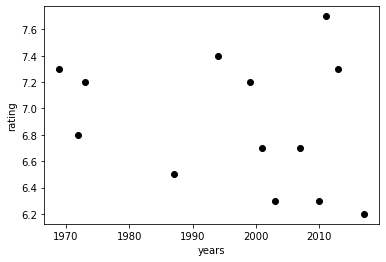

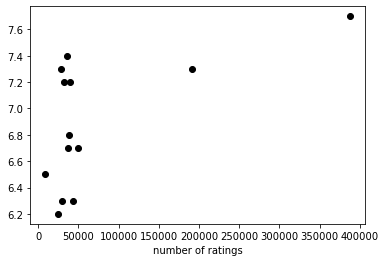

In [331]:
plt.ylabel("rating")
plt.scatter(X_test_cont_w_log['year'], y_test,  color='black')
plt.xlabel('years')
plt.show()
#plt.plot(X_test_cont_w_log['year'], y_pred, color='blue', linewidth=3)
plt.scatter(X_test_cont_w_log['rating_count'], y_test,  color='black')
plt.xlabel('number of ratings')
plt.show()

### Fit to only  `log_rating_count` and maybe `log_year`


In [332]:
lr = LinearRegression()

X_train_logs_only = X_train_scaled_df[['year','log_rating_count']]

X_test_logs_only = X_test_scaled_df[['year','log_rating_count']]



lr.fit(X_train_logs_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_logs_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.35
r2: 0.44


## Repartition data set to analyze `worldwide_gross`

In [ ]:
films_df_reordered

In [ ]:
films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
#films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits.iloc[:,8:15]


In [ ]:
new_analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits = films_to_analyze_profits[new_analysis_columns]

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'duration'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating_count'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'James Stewart'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Cary Grant'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Grace Kelly'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

### Repartition data set to analyze `worldwide_gross` in terms of `budget` etc.

In [ ]:

films_to_analyze_profits_and_budget=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['budget'].notnull()) & (films_df_reordered['budget']!='')& (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits_and_budget.iloc[:,8:15]
films_to_analyze_profits_and_budget


In [ ]:
new_analysis_columns_budget = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'budget', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits_and_budget = films_to_analyze_profits_and_budget[new_analysis_columns_budget]

In [ ]:
x_label = 'year'
y_label = 'budget'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))